# After sales text clustering using Doc2Vec
## Enhanced corpus with more data

In [2]:
import pandas as pd
import numpy as np
import spacy

nlp = spacy.load("es_core_news_sm")
# nlp = spacy.load('es_core_news_md')
# nlp = spacy.load('es_core_news_sm')
import multiprocessing
from datetime import date
import matplotlib.pyplot as plt
import os
import gensim.models.doc2vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

pd.options.mode.chained_assignment = None

data_version = "2024-05-14"
corpus_version = "2024-05-15"
model_version = "2024-05-15"
data_base_path = f"../DATA/processed/"
model_base_path = f"../MODELS/{data_version}"

In [3]:
# Function to preprocess the text
def preprocess_text(docs):
    # Ensure all entries are strings
    docs = docs.fillna("").astype(str)
    # Process the text
    texts = [doc for doc in nlp.pipe(docs, disable=["ner", "parser"])]
    processed_texts = []
    for doc in texts:
        tokens = [
            token.text.lower()
            for token in doc
            if not token.is_punct and not token.is_stop and not token.is_space
        ]
        processed_texts.append(" ".join(tokens))
    return processed_texts

In [4]:
# Class Model with comments
class CommentedDoc2Vec(Doc2Vec):
    def __init__(self, comment="", **kwargs):
        super().__init__(**kwargs)
        self.comment = comment

In [5]:
# Load train corpus from disk
corpus = pd.read_csv("../DATA/processed/2024-05-15/corpus_spanish.csv", sep="¬")
corpus["text_to_analyse"] = (
    corpus["text_to_analyse"].fillna("").astype(str)
)  # Ensure all values are strings
corpus["processed_text"] = preprocess_text(corpus["text_to_analyse"])
corpus = corpus[corpus["processed_text"] != ""]
# corpus = pd.read_csv(f'../DATA/processed/{corpus_version}/corpus_processed.csv', sep='¬')
corpus.sample(10)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_21268\1303233110.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  corpus = pd.read_csv("../DATA/processed/2024-05-15/corpus_spanish.csv", sep="¬")


,text_to_analyse,language,processed_text
53673,Se selecciona pulsando el icono de la mano sit...,es,selecciona pulsando icono mano situado botón o...
74754,Alimentação própria através de fonte de alimen...,pt,alimentação própria através fonte alimentação ...
174425,Alimentación \nmediante bus de expansión del s...,es,alimentación bus expansión sistema
136666,Compruebe los LEDs de \nla pasarela (Autodiagn...,es,compruebe leds pasarela autodiagnóstico
146704,EN \nFR \nIT \nPT \nDE \n Dirección zona \nSe...,es,fr it pt dirección zona seleccione zona asocia...
10695,DEVOLUCIÓN DE REPUESTOS ENTREGADOS A NOSOTROS ...,pt,devolución repuestos entregados asistencia gar...
33386,"Si el tacto no obtiene respuesta, \naparecerá ...",es,tacto obtiene respuesta aparecerá código error
161155,"Para ello pulse sobre SW1, el LED D19 se encen...",es,pulse sw1 led d19 encenderá color rojo fijo
110923,Dobre o excesso de chapa para fixar as bocas....,pt,dobre excesso chapa fixar as bocas aparafuse p...
48409,Crear un Programa................................,es,crear programa


In [6]:
common_kwargs = dict(
    vector_size=200,
    epochs=20,
    min_count=2,
    sample=0,
    workers=multiprocessing.cpu_count(),
    negative=5,
    hs=0,
    seed=0,
)

In [7]:
# PV-DBOW plain
model = CommentedDoc2Vec(
    dm=0,
    comment=f"PV-DBOW-"
    f"v_size {common_kwargs['vector_size']}-"
    f"epochs {common_kwargs['epochs']}-"
    f"hs {common_kwargs['hs']}-"
    f"sample {common_kwargs['sample']}-"
    f"negative {common_kwargs['negative']}-"
    f"min_count {common_kwargs['min_count']}-"
    f"corpus {corpus_version}",
    **common_kwargs,
)

In [8]:
# Create TaggedDocument objects
tagged_data = [
    TaggedDocument(words=doc.split(), tags=[i])
    for i, doc in enumerate(corpus["processed_text"])
]

In [9]:
# Build the vocabulary
model.build_vocab(tagged_data)
print("Model: %s : vocabulary scanned & state initialized" % model.comment)

Model: PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2-corpus 2024-05-15 : vocabulary scanned & state initialized


In [10]:
# Train the model using the Corpus
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
print("%s training completed" % model.comment)

PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2-corpus 2024-05-15 training completed


In [11]:
# Save the model
os.makedirs(model_base_path, exist_ok=True)
model_name = (
    f"{model_base_path}/{type(model).__name__}_{model.comment.replace(' ', '_')}.model"
)
model.save(model_name)
print(f"Model saved at {model_name}")

Model saved at ../MODELS/2024-05-14/CommentedDoc2Vec_PV-DBOW-v_size_200-epochs_20-hs_0-sample_0-negative_5-min_count_2-corpus_2024-05-15.model


## Load the model and the data and infer vectors

In [12]:
# Load the model
model_name = "../MODELS/2024-05-15/CommentedDoc2Vec_PV-DBOW-v_size_200-epochs_20-hs_0-sample_0-negative_5-min_count_2.model"
model = CommentedDoc2Vec.load(model_name)
print(f"Model {model} loaded")

Model CommentedDoc2Vec<"PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2",dbow,d200,n5,mc2,t8> loaded


In [13]:
# Load the data to analyse
text_to_analyse_clean = pd.read_csv(
    f"{data_base_path}/{data_version}/text_to_analyse_clean.csv", sep="¬"
)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_21268\3126210761.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_analyse_clean = pd.read_csv(


In [14]:
# Infer vectors for the text_to_analyse
text_to_analyse_clean["processed_text"] = preprocess_text(
    text_to_analyse_clean["text_to_analyse"]
)
text_to_analyse_clean["vector"] = text_to_analyse_clean["processed_text"].apply(
    lambda x: model.infer_vector(x.split())
)

In [15]:
text_to_analyse_clean.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4,processed_text,vector
1132,A2TKCZ5I39,3495.0,CAMBIO PASARELAS,NaN,El termostato aparece con todos los simbolos e...,AZCE6THINKRB,CAMBIO PASARELAS El termostato aparece con to...,AZCE6THINKRB,100.0,AZCE6THINKRB,...,1.0,250.0,91.0,2.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,THINK,cambio pasarelas termostato aparece simbolos r...,"[0.023473242, -0.09876833, -0.23351018, -0.096..."
16155,Z2TLZ2ZQE1,51021.0,Ha dejado de funcionar,MODULO CTROL.ELEM.RADIANTE 32 Z.AIRZONE,Ha dejado de funcionar,AZDI6OUTPUT8 --,Ha dejado de funcionar MODULO CTROL.ELEM.RADIA...,AZDI6OUTPUT8,100.0,AZDI6OUTPUT8,...,1.0,251.0,94.0,NaN,SISTEMAS DE ZONAS,ACUAZONE (DI6),MODULOS DE CONTROL,NaN,dejado funcionar modulo ctrol.elem.radiante 32...,"[-0.020843634, 0.019914225, -0.016367005, -0.1..."
14011,AM5SAMDV17,44333.0,LOS MANDOS NO PARAN DE REINICIARSE,REJ MOTOR INTEL DOBLE REG RINT 600X100 BL,SON LOS MANDOS LOS QUE SE ENVIAN,AZCE6BLUEFAC,LOS MANDOS NO PARAN DE REINICIARSE REJ MOTOR I...,AZCE6BLUEFACECB,89.0,AZCE6BLUEFACECB,...,1.0,250.0,91.0,1.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,BLUEFACE,mandos paran reiniciarse rej motor intel doble...,"[-0.020008937, 0.16397232, 0.022052694, -0.104..."
19247,Z21LYWSB84,62556.0,NaN,NaN,Boleto 73151,AZCE6IBPRO6,Boleto 73151 AZCE6IBPRO6,AZCE6IBPRO6,100.0,AZCE6IBPRO6,...,1.0,250.0,90.0,NaN,SISTEMAS DE ZONAS,FLEXA (CE6),CENTRALES,NaN,boleto 73151 azce6ibpro6,"[0.017194645, 0.029378144, -0.025409447, -0.05..."
1917,A2WWCZPH6F,5963.0,Pb con asociación lite 10C+,Piensa cableado,Sav,AZCE6THINKCB,Pb con asociación lite 10C+ Piensa cableado Sa...,AZCE6THINKCB,100.0,AZCE6THINKCB,...,1.0,250.0,91.0,2.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,THINK,pb asociación lite 10c+ piensa cableado sav az...,"[0.13862468, 0.15090017, -0.3165455, -0.153735..."
22997,NZIXM55K57,79276.0,REPOSICION CENTRAL AZCE8CB1MOT - AUTORIZADO PO...,Centro de sistema Airzone Flexa 3.0 (CE8),REPOSICION,AZCE8CB1MOT,REPOSICION CENTRAL AZCE8CB1MOT - AUTORIZADO PO...,AZCE8CB1MOT,100.0,AZCE8CB1MOT,...,1.0,270.0,90.0,NaN,SISTEMAS DE ZONAS,FLEXA 4.0,CENTRALES,NaN,reposicion central azce8cb1mot autorizado técn...,"[0.016632354, -0.14637999, 0.0153412, -0.10363..."
14718,B29LZWVR71,46534.0,MATERIALESPM3761548,SERVIDOR WEBWIFI,DEVOLUCION WEBSERVER WIFI,AZXWSCLOUDETH,MATERIALESPM3761548 SERVIDOR WEBWIFI DEVOLUCIO...,AZXWSCLOUDETH,100.0,AZXWSCLOUDETH,...,1.0,260.0,93.0,NaN,SISTEMAS DE ZONAS,COMUNES,WEB SERVER & INTEGRACION,NaN,materialespm3761548 servidor webwifi devolucio...,"[-0.017105961, 0.05883985, -0.1142685, -0.0293..."
20520,NJIBLJXH6A,67954.0,CAMBIAR LA CENTRAL ACUAZONE Y LA CCP. POR UNA ...,CENTRAL PRODUCCION,NO FUNCIONA EL PUERTO DOMOTICO,AZX6CCP,CAMBIAR LA CENTRAL ACUAZONE Y LA CCP. POR UNA ...,AZX6CCP,100.0,AZX6CCP,...,1.0,260.0,92.0,NaN,SISTEMAS DE ZONAS,COMUNES,CONTROLADORES CENTRALIZADOS,NaN,cambiar central acuazone ccp gawi web server c...,"[-0.18626769, -0.04501398, 0.011114308, -0.029..."
14335,BNBQBMPO5D,45342.0,"No sabemos lo que le pasa, el cliente me ha da...",CCP CON SERVIDOR WEB,"No sabemos lo que le pasa, el cliente me ha da...",AZX6CCPWSCC,"No sabemos lo que le pasa, el cliente me ha da...",AZX6CCPWSCC,100.0,AZX6CCPWSCC,...,1.0,260.0,92.0,NaN,SISTEMAS DE ZONAS,COMUNES,CONTROLADORES CENTRALIZADOS,NaN,pasa cliente numero incidencia explicarme ccp ...,"[-0.12879, -0.10234429, 0.01990286, 0.01999060..."
20666,LZWZLZTJD3,68620.0,"Solicito una antena remota, podríamos tener va...",Antena remota,Instalación de una antena remota.,000,"Solicito una antena remota, podríamos tener va...",50-CHP-EMB-000,100.0,50-CHP-EMB-000,...,5.0,14.0,24.0,181.0,SEMITERMINADOS,OBS_PLENUMS,PLENUM MOTORIZADO,BASE DE PLENUM,solicito antena remota podríamos gracias anten...,"[0.18050823, 0.1581178, -0.114798225, -0.14642..."


## Calculate the similarity between the texts

In [17]:
# Read list of errors
errors = pd.read_csv("../DATA/TablaTipoErrorPostventa.csv", sep=";", header=0)[
    ["Código", "CODCAR3", "CODCAR2", "DESCFAM", "Motivo General", "DESCRIPCION"]
]
errors.columns = [
    "ID_ERROR",
    "CODCAR3",
    "CODCAR2",
    "DESCFAM",
    "MOTIVO",
    "DESCRIPCION",
]  # Rename columns
errors["DESCRIPCION"] = (
    errors["MOTIVO"] + " " + errors["DESCRIPCION"]
)  # Concatenate MOTIVO and DESCRIPCION
errors["CODCAR2"] = errors["CODCAR2"].str.replace("-", "0").astype(int)  # Clean CODCAR2

In [18]:
# Infer vector for errors
errors["description_processed"] = preprocess_text(errors["DESCRIPCION"])
errors["vector"] = errors["description_processed"].apply(
    lambda x: model.infer_vector(x.split())
)

In [19]:
errors

,ID_ERROR,CODCAR3,CODCAR2,DESCFAM,MOTIVO,DESCRIPCION,description_processed,vector
0,3.01,91,0,TERMOSTATOS,Termostato bloqueado,"Termostato bloqueado No funciona nada, ha para...",termostato bloqueado funciona parado funcionar...,"[-0.026727194, 0.13381635, 0.086489394, -0.038..."
1,3.02,91,0,TERMOSTATOS,Fallo de comunicaciones,"Fallo de comunicaciones No comunica, no funcio...",fallo comunicaciones comunica funciona comunic...,"[-0.12989175, 0.0047399616, -0.0849931, 0.0372..."
2,3.03,91,0,TERMOSTATOS,Fallo de pantalla,"Fallo de pantalla Pantalla no funciona, no se ...",fallo pantalla pantalla funciona ve pantalla e...,"[-0.12047569, 0.029273324, -0.11568944, -0.047..."
3,3.04,91,0,TERMOSTATOS,No funciona el táctil,No funciona el táctil Pantalla no funciona el ...,funciona táctil pantalla funciona tactil panta...,"[-0.040906627, 0.026833113, -0.16702133, -0.04..."
4,3.05,91,0,TERMOSTATOS,Error de lectura de temperatura,Error de lectura de temperatura No le temperat...,error lectura temperatura temperatura correcta...,"[-0.09521706, -0.11786434, -0.21673048, -0.055..."
...,...,...,...,...,...,...,...,...
109,4.49,100,0,CALIDAD DE AIRE,Otro motivo,Otro motivo Motivos que no se encajan en otros,motivo motivos encajan,"[0.061442193, -0.048970424, 0.00343622, -0.104..."
110,4.61,88,0,ACCESORIOS,Error de alimentación,NaN,,"[-0.0004069796, -0.00014479563, -0.0015196655,..."
111,4.62,88,0,ACCESORIOS,Error de funcionamiento,NaN,,"[-0.000567009, -0.00029797867, -0.0019376224, ..."
112,4.63,88,0,ACCESORIOS,Error estético,NaN,,"[-0.0012983617, -0.0010532219, -0.0018639148, ..."


In [20]:
from sklearn.metrics.pairwise import cosine_similarity


def calculate_cosine_score(vector, vector_error):
    return cosine_similarity(vector.reshape(1, -1), vector_error.reshape(1, -1))[0][0]


def calculate_mean_cosine_score(vector, vector_error, n=5):
    if vector.size == 0 or vector_error.size == 0:
        return np.nan  # Return NaN if there's no vector to compare
    cosine_scores = []
    for i in range(n):
        cosine_scores.append(calculate_cosine_score(vector, vector_error))
    return np.mean(cosine_scores)

In [21]:
# Calculate the cosine similarity between the text_to_analyse and the errors
for index, row in errors.iterrows():
    # Create a condition for filtering
    condition = text_to_analyse_clean["CAR3"] == row["CODCAR3"]
    if row["CODCAR2"]:
        condition &= text_to_analyse_clean["CAR2"] == row["CODCAR2"]

    if not text_to_analyse_clean.loc[condition, "vector"].empty:
        text_to_analyse_clean.loc[condition, f'cosine_similarity_{row["ID_ERROR"]}'] = (
            text_to_analyse_clean.loc[condition, "vector"].apply(
                lambda x: calculate_mean_cosine_score(x, row["vector"])
            )
        )

    print(f"Error {row['ID_ERROR']} calculated")

Error 3.01 calculated
Error 3.02 calculated
Error 3.03 calculated
Error 3.04 calculated
Error 3.05 calculated
Error 3.08 calculated
Error 3.09 calculated
Error 3.21 calculated
Error 3.22 calculated
Error 3.23 calculated
Error 3.24 calculated
Error 3.28 calculated
Error 3.29 calculated
Error 3.41 calculated
Error 3.42 calculated
Error 3.43 calculated
Error 3.44 calculated
Error 3.45 calculated
Error 3.48 calculated
Error 3.49 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62

In [29]:
text_to_analyse_clean.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69,highest_score,highest_score_error
1749,B2DLAZ5JA2,5555.0,TEL PENSAR RADIO REF NOVOA HS\r\nSET comprado ...,piensa en la radio,alambre HS,AZCE6THINKRB,TEL PENSAR RADIO REF NOVOA HS\r\nSET comprado ...,AZCE6THINKRB,100.0,AZCE6THINKRB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.551619,3.09
12457,AHBKZWXQ93,39578.0,No funciona.,SERVIDOR WEB WIFI REFERENCIA,NO FUNCIONA,AZX6WSC5GER,No funciona. SERVIDOR WEB WIFI REFERENCIA NO F...,AZX6WSC5GER,100.0,AZX6WSC5GER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.723499,3.22
9878,LWLSLGDOD5,31785.0,MANDO QUE NO SE ENCIENDE,MANDO BLUEFACE,MANDO QUE NO SE ENCIENDE,AZCE6BLUEFACECB,MANDO QUE NO SE ENCIENDE MANDO BLUEFACE MANDO ...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.757838,3.04
5315,NG-YLPVR6C,15352.0,El termostato cambia de una pantalla a otra si...,TERMOSTATO CARA AZUL,EL TERMOSTATO PASA DE UNA PANTALLA A OTRA SIN ...,AZCE6BLUEFACECB,El termostato cambia de una pantalla a otra si...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.729152,3.04
2774,A2CACZDI98,8435.0,NO FUNCIONA DIM4,DIM4,"NO FUNCIONA, SE SOLICITA ENVIO EN GARANTIA A L...",DIM4,"NO FUNCIONA DIM4 DIM4 NO FUNCIONA, SE SOLICITA...",DIM4,100.0,DIM4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.715497,3.89
15166,ZNBLAMPVC4,47956.0,Necesitamos 2 WS 5G para sustituir por los ant...,NaN,NECESITMAOS 2 UDS. 5G PARA SUSTITUIRLOS,AZX6WEBSCLOUDR,Necesitamos 2 WS 5G para sustituir por los ant...,AZX6WEBSCLOUDR,100.0,AZX6WEBSCLOUDR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.677637,3.29
20641,LJKAM51HB1,68490.0,"Tarjeta defectuosa, vista con el técnico de AI...",NaN,Tarjeta HS vista con el técnico de AIR ZONE,AZCE8CB1IAQE,"Tarjeta defectuosa, vista con el técnico de AI...",AZCE8CB1IAQE,100.0,AZCE8CB1IAQE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524132,3.89
1757,CMRNAJXLD9,5569.0,"NUEVO FUNCIONAL PLUS, SERVIDOR WEB OFRECIDO",SERVIDOR WEB AIRZONE NUBE WIFI,GRATIS,AZX6WEBSCLOUDR,"NUEVO FUNCIONAL PLUS, SERVIDOR WEB OFRECIDO SE...",AZX6WEBSCLOUDR,100.0,AZX6WEBSCLOUDR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587182,3.22
24220,LZGDL5ZG55,85275.0,PASARELA AZX6QADAPT3FU2 DEFECTUOSA. SOLICITAMO...,AZX6QADAPT3FU2 PASARELA COMUNICACION,PASARELA AZX6QADAPT3FU2 DEFECTUOSA. SOLICITAMO...,AZX6QADAPT3FU2 P,PASARELA AZX6QADAPT3FU2 DEFECTUOSA. SOLICITAMO...,AZX6QADAPT3FU2,100.0,AZX6QADAPT3FU2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.717128,3.49
190,AJUCZZQTA6,713.0,"Central de producción CCPC , no funciona el re...",CENTRAL DE PRODUCCION,NO FUNCIONA RELE SUELO RADIANTE,AZXCCPC,"Central de producción CCPC , no funciona el re...",AZXCCPC,100.0,AZXCCPC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.578931,3.89


In [23]:
# Save text_to_analyse to disk
# text_to_analyse_clean.to_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig', index=False)

In [24]:
# Load text_to_analyse from disk
# text_to_analyse_clean = pd.read_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig')

In [30]:
cosine_columns = [
    col for col in text_to_analyse_clean.columns if "cosine_similarity_" in col
]
text_to_analyse_clean[cosine_columns] = text_to_analyse_clean[cosine_columns].fillna(
    0
)  # Fill NA with 0
text_to_analyse_clean.loc[:, "highest_score"] = text_to_analyse_clean[
    cosine_columns
].max(axis=1)
text_to_analyse_clean.loc[:, "highest_score_error"] = (
    text_to_analyse_clean[cosine_columns]
    .idxmax(axis=1)
    .apply(lambda x: x.split("_")[-1])
)

In [31]:
text_to_analyse_clean.head(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69,highest_score,highest_score_error
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727759,3.89
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752803,3.04
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.596175,3.89
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.682236,4.09
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515645,3.89
5,ZJYEZZYZFA,87.0,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,AZAMFANCOILC,100.0,AZAMFANCOILC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542509,3.89
6,ZPEZZJYUE4,106.0,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo...",AZXEQADAPMHI,100.0,AZXEQADAPMHI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448436,3.49
7,AZUCYPEX2B,114.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,NaN,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640376,3.03
8,AZUCYPEX2B,115.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,NaN,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3TACTOCSB,100.0,AZC3TACTOCSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.638030,3.09
9,ZJUWZZIT34,116.0,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,NaN,2 UNIDADES. TAPAS TRASERAS ROTAS EN VARIAS OCA...,AZC3BLUEFECOSB,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.692694,3.09


In [32]:
top10_per_error = (
    text_to_analyse_clean[
        ["codigo", "text_to_analyse", "highest_score", "highest_score_error"]
    ]
    .groupby("highest_score_error", group_keys=False)
    .apply(lambda x: x.nlargest(10, "highest_score"))
    .reset_index(drop=True)
)

top10_per_error.head(500)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_21268\2696173052.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  text_to_analyse_clean[


,codigo,text_to_analyse,highest_score,highest_score_error
0,AG9MZWDO8C,"No funciona, no hace funcionar el sistema. NO...",0.840416,3.01
1,AMSYB51L32,se queda la pantalla en rojo y no funciona el ...,0.813088,3.01
2,BGTGYGSU7C,TERMOSTATO QUE SE BLOQUEA SOLO Y NO FUNCIONA B...,0.811716,3.01
3,BMHSAGHUF9,Se queda la pantalla bloqueada al inicio cuand...,0.809715,3.01
4,AMLQY2HQ2B,TERMOSTATO SITUADO EN LA COCINA NO FUNCIONA CO...,0.808031,3.01
...,...,...,...,...
152,B2PQZMTT33,El bypass de conductos de vuestro pedido 21901...,0.722800,4.69
153,AHBTBGHX8C,DEVOLUCIÓN 2 PALLETS POR ROTURA TRANSPORTE ZON...,0.709714,4.69
154,L5OVMZPG51,PERSIANA ROTO OBTURADOR EL PLENO LLEGÓ CON EL ...,0.705696,4.69
155,ZNBLA2TVDF,SONDAS EN GARANTIA Segun correo electronico r...,0.703092,4.69


In [28]:
text_to_analyse_clean[text_to_analyse_clean["codigo"] == "MMHSNG1V2C"][
    ["codigo", "text_to_analyse", "highest_score", "highest_score_error"]
]

,codigo,text_to_analyse,highest_score,highest_score_error
11128,MMHSNG1V2C,WEBSERVER QUE HA ESTADO FUNCIONANDO DURANTE TR...,0.625601,3.22


 ## Visualize the results

In [33]:
results = text_to_analyse_clean[["vector", "highest_score_error"]]
# Convert string representations of lists to actual numpy arrays
results["vector"] = results["vector"].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else x
)

In [34]:
# Expand each vector into its own column
expanded_vectors = results["vector"].apply(pd.Series)
expanded_vectors.columns = [f"vector_{i}" for i in range(expanded_vectors.shape[1])]
results = pd.concat([results, expanded_vectors], axis=1)

In [35]:
X = results.drop(["vector", "highest_score_error"], axis=1)
y = pd.to_numeric(results["highest_score_error"], errors="coerce")

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

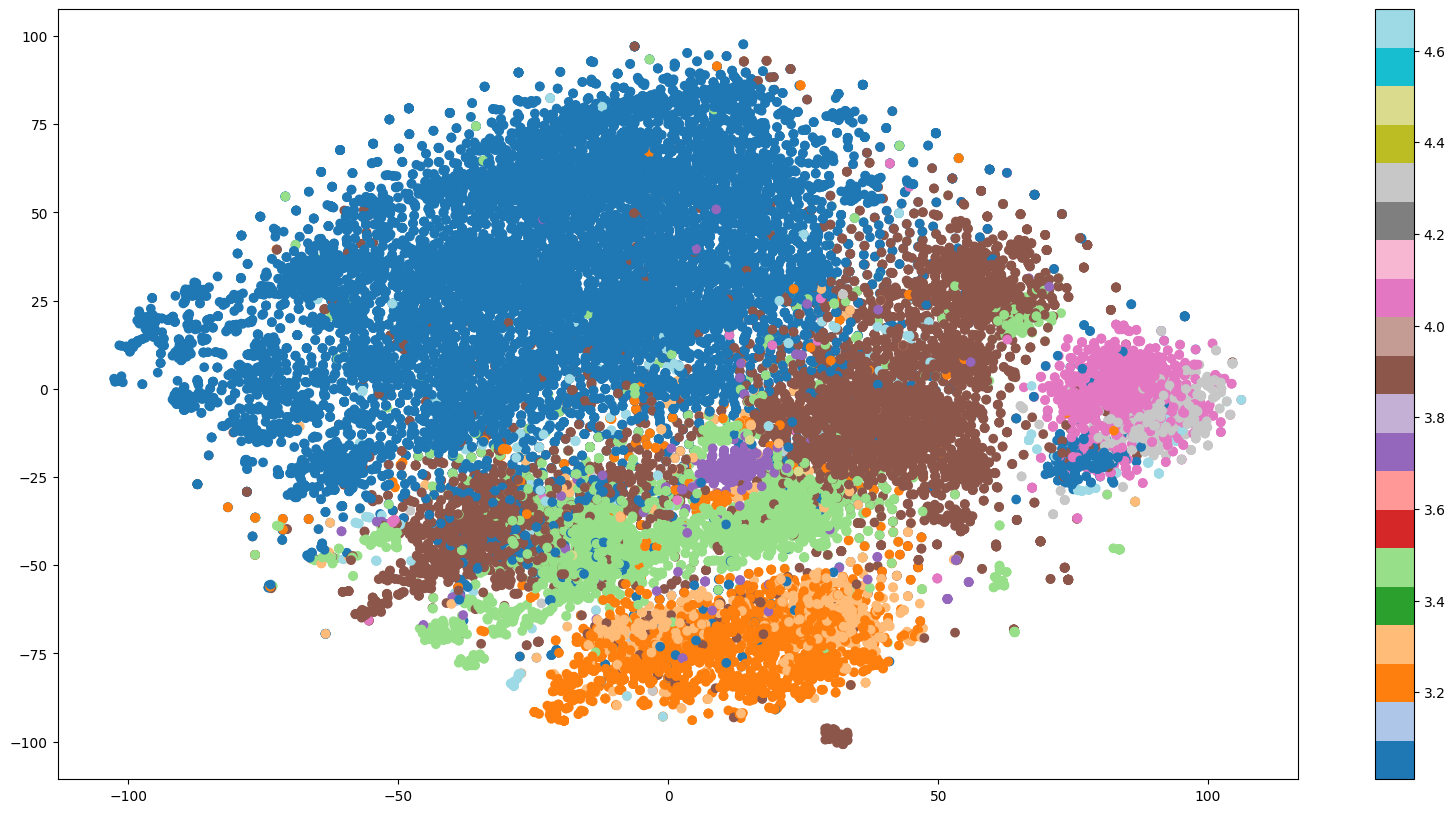

In [37]:
# Plot the results
plt.figure(figsize=(20, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab20")
plt.colorbar()
plt.show()

In [38]:
# Create TSNE with 3 components
tsne = TSNE(n_components=3, random_state=0)
X_tsne_3d = tsne.fit_transform(X)

In [40]:
# Plot data in 3D
%matplotlib qt6

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y, cmap="tab20"
)
# Add legend
plt.legend(*scatter.legend_elements(num=10), title="Classes")
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")
plt.title("Doc2Vec")
plt.show()